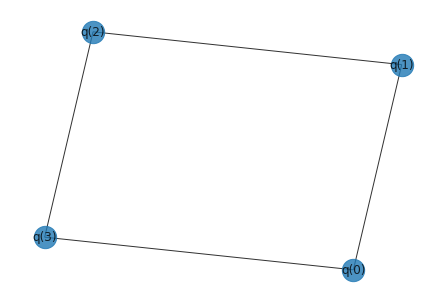

In [22]:
import networkx as nx
from networkx import Graph
from cirq import LineQubit

g = Graph()
nodes = [LineQubit(i) for i in range(4)]
edges = [(nodes[i], nodes[(i + 1) % 4]) for i in range(4)]
g.add_nodes_from(nodes)
g.add_edges_from(edges)
nx.draw(g, with_labels=True, alpha=0.8, node_size=500)

In [23]:
from cirq import Rx
from sympy import Symbol


def mixer(g: Graph, beta: Symbol):
    return [Rx(rads=2 * beta)(q) for q in list(g.nodes())]

In [24]:
from openfermion import Rzz


def problem(g: Graph, gamma: Symbol):
    return [Rzz(rads=2 * gamma)(i, j) for i, j in g.edges()]

In [25]:
from cirq import Circuit, H, measure, Moment


def create_qaoa_circ(g: Graph, beta: Symbol, gamma: Symbol):
    return Circuit(
        H.on_each(*nodes),
        problem(g, gamma),
        mixer(g, beta),
        problem(g, gamma),
        mixer(g, beta),
        measure(*nodes, key="cut")
    )

In [26]:
from functools import reduce

def maxcut_obj(x: str, g: Graph):
    return reduce(lambda obj, e: obj - (1 if x[e[0].x] != x[e[1].x] else 0), g.edges(), 0)

In [27]:
from collections import Counter

def compute_expectation(cuts: Counter, g: Graph):
    sum, count = reduce(lambda t, c: (t[0] + (maxcut_obj(c, g) * cuts[c]), t[1] + cuts[c]), cuts, (0, 0))
    return sum / count

In [28]:
from cirq import Simulator


def get_expectation(g: Graph, shots=512):
    sim = Simulator()

    def execute_circ(params: list[float]):
        beta = Symbol("beta")
        gamma = Symbol("gamma")
        qc = create_qaoa_circ(g, beta, gamma)
        result = sim.run(qc, {beta: params[0], gamma: [params[1]]}, shots)
        return compute_expectation(result.histogram(key="cut", fold_func=lambda x: ''.join(list(map(lambda i: str(i), x)))), g)

    return execute_circ

In [29]:
from scipy.optimize import minimize

expectation = get_expectation(g)
res = minimize(expectation, [1.0, 1.0], method='COBYLA')
res

     fun: -3.96875
   maxcv: 0.0
 message: 'Optimization terminated successfully.'
    nfev: 30
  status: 1
 success: True
       x: array([1.07494456, 1.04195764])

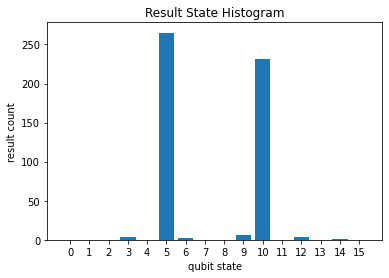

In [30]:
from cirq import plot_state_histogram
import matplotlib.pyplot as plt

beta = Symbol("beta")
gamma = Symbol("gamma")
qc = create_qaoa_circ(g, beta, gamma)
result = Simulator().run(qc, {beta: res.x[0], gamma: res.x[1]}, 512)
plot_state_histogram(result, plt.subplot())

plt.show()